# Part 1 - Generate hydrographs from digital elevation model (DEM)
This notebook demonstrates with a small examplary region (basin upstream of Altenahr, West Germany) how geomorphological unit hydrographs can be derived from a digital elevation model with a spatial resolution of 25m x 25m. Later on the hydrographs are the basis for the quick runoff (QR) modelling and allow for a large number of counterfactual simulations (see notebook `Modelling of quick runoff.ipynb`).

In [1]:
import counterfactual_preparation as cp
from IPython.display import Image
import geopandas as gpd
import glob
import os
import shutil

## Creation of basic rasters
First we just need a DEM. Follwing rasters are then created using PCRaster functions. The detailed code can be viewed in the script `counterfactual functions.py`. All results are stored in the folder **output**. **The coordinate reference system for all files is "EPSG:3035"**.

Following data is supplied in this repository in the folder **input**:
- *dem.map*: DEM (European Commission, 2016) of the region of the Altenahr basin
- *corine.gpkg*: CORINE (BKG, 2018) landuse file of the Altenahr basin
- *buek250_cn_classes.gpkg*: soil classes derived from soil map BUEK250 (BGR, 2018) and manually classified to four soil classes according to the SCS-CN method (U.S. Department of Agriculture-Soil Conservation Service, 1972).
- *scs.csv*:table which connects CORINE landuse codes (CLC18) to curve number values
- *cn_sm_classes.csv*: table of increasing curve numbers for soil moisture class 2 and the corresponding values for soil moisture class 1 and 3.

Following data sets are computed in this step and saved in **output/gis**. These files are the basis for the computation of hydrographs.

- sink filling is applied to the DEM (*dem_filled.map*)
- flow direction grid (*flowdir.map*)
- flow accumulation grid (*accu.map*)
- raster and shapefile containing the subbasins (*subbasins.gpkg*, *subbasins_adjusted.map*)
- raster containing the friction values, needed for traveltime calculation (*friction_maidment.map*)
- raster containing the traveltime (in minutes, based on the method by Maidment et al., 1996) of every cell to its respective outlet (*tt_complete.map*)
- shapefile containing the curve number values for every basin and soil moisture class (*soil_landuse_classes.gpkg*). This file is derived from the soil map BUEK250 and the landuse (files *buek250_cn_classes.gpkg* and *corine.gpkg*)
Outlets are determined by the intersection of streams with the Strahler-oder 7 upwards with the functions cf.create_outlet_raster and cf.find_intersects and stored in the raster "outlets.map".

Then outlet and flow direction raster are used to delineate the subbasins. Very small subbasins (< 0.45 km²) are removed with the function `counterfactual_functions.remove_small_subbasins`.

In [ ]:
files = glob.glob('output/gis/*')
print("Removing previous files")
for f in files:
    os.remove(f)

if not os.path.exists("output"):
    os.mkdir("output")

if not os.path.exists("output/gis"):
    os.mkdir("output/gis")

In [ ]:
#this step takes about two minutes
cp.create_basic_files()

<Axes: >

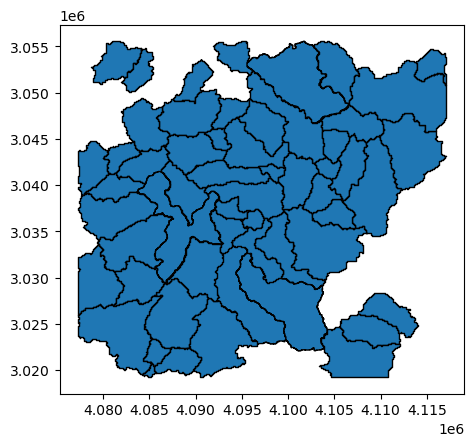

In [4]:
subbasins = gpd.read_file("output/gis/subbasins.gpkg")
subbasins.plot(edgecolor="black")

## Create the files for the individual subbasins
Now that the basic rasters for the whole area have been generated, we can clip the results to the individual subbasins and calculate the hydrographs and curve numbers for each subbasin. The results are stored in **output/basins** and are the basis for the hydrological modelling later on. Plots of the hydrographs and the traveltimes rasters for every subbasin are stored in **output/giuh_plots**. 

In [5]:
#clean up if you want to compute the hydrographs again
files = glob.glob('output/basins/*')
print("Removing previous basin files")
for f in files:
    shutil.rmtree(f)
    
files = glob.glob('output/giuh_plots/*')
print("Removing previous plots")
for f in files:
    os.remove(f)

Removing previous basin files
Removing previous plots


In [ ]:
subbasins = gpd.read_file("output/gis/subbasins.gpkg")
cp.hydrograph_and_cn_for_subbasins(subbasins.DN.to_list(), plot_giuh=True)

### View results
Here you can view the traveltime raster and corresponding hydrographs for every subbasin. Just change the subbasin id below. The red cross indicates the outlet of the catchment.

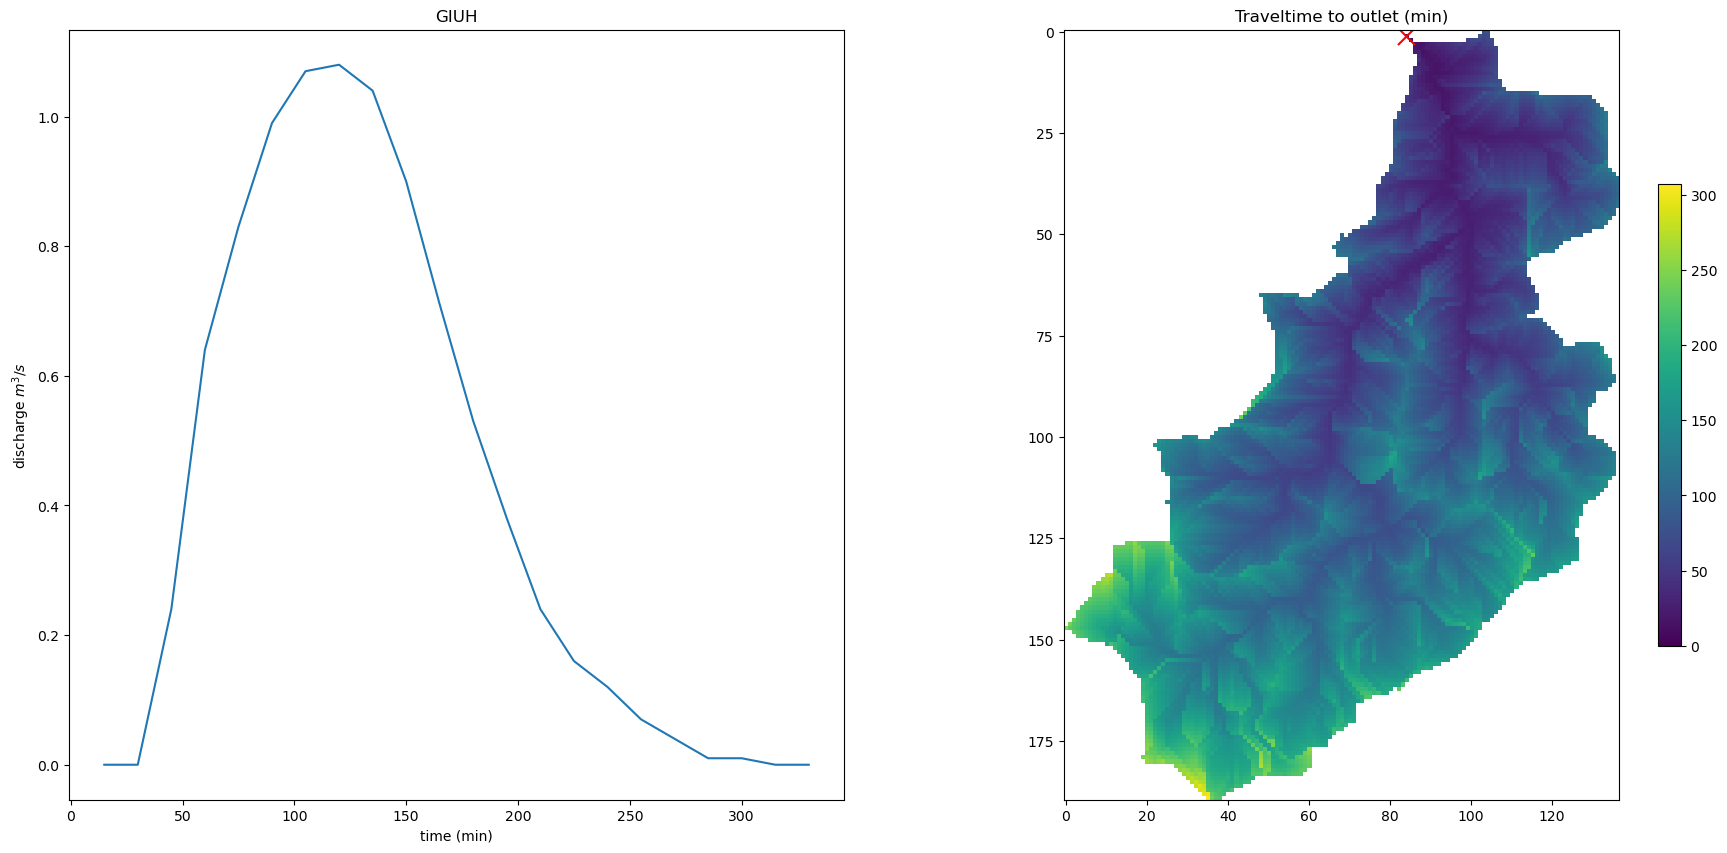

In [8]:
subbasin_id = 3
Image(f'output/giuh_plots/{subbasin_id}_giuh.png')

## Flow order 
Now that all the files for the subbasins are generated, we can derive the information, which subbasins are headwater basins and which subbasins are flowing into each other. We can also determine how long it takes the flow to reach the next downstream outlet. All this information is needed later for the hydrological modelling and the superposition of the hydrographs. The information is stored in the file */input/generated/floworder.csv*.
Additionally, we store this information for every subbasin in a shapefile which comes in handy for later analysis (*input/generated/subbasins_info.gpkg*).

In [ ]:
cp.get_floworder()

If all these steps functioned correctly, you can now proceed to "Part 2 - Rainfall input"

In case you want to try to process other rasters, you can convert them to PCRaster-format using gdal:
`os.system(f'gdal_translate -of "PCRaster" -a_srs EPSG:3035 {input_path}dem.tif {input_path}dem.map')`

If this does not work (maybe on windows?) then there is also a Python API for GDAL.

# References

*BGR: BÜK200 V5.5, BGR, https://www.bgr.bund.de/DE/Themen/Boden/Informationsgrundlagen/Bodenkundliche_Karten_Datenbanken/
BUEK200/buek200_node.html, 2018. Last accessed 13 December 2023*

*BKG: CORINE CLC5-2018, https://gdz.bkg.bund.de/index.php/default/open-data/corine-land-cover-5-ha-stand-2018-clc5-2018.html,
2018. Last accessed 13 December 2023.*

*European Commission: Digital Elevation Model over Europe (EU-DEM), Eurostat, https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/
elevation/eu-dem/eu-dem-dd, 2016. Last accessed 13 December 2023.*

*Maidment, D., Olivera, F., Calver, A., Eatherall, A., and Fraczek, W.: Unit hydrograph derived from a spatially distributed velocity field, Hy-
drological processes, 10, 831–844, https://doi.org/https://doi.org/10.1002/(SICI)1099-1085(199606)10:6<831::AID-HYP374>3.0.CO;2-
N, 1996.*

*U.S. Department of Agriculture-Soil Conservation Service: Estimation of Direct Runoff From Storm Rainfall, SCS National Engineering
Handbook, Section 4, Hydrology. Chapter 10, 1972.*